   *What happened with Legos? They used to be simple. Oh come on, I know you know what I'm talking about. Legos were simple. Something happened out here while I was inside. Harry Potter Legos, Star Wars Legos, complicated kits, tiny little blocks. I mean I'm not saying it's bad, I just wanna know what happened." -- Prof. Cane, [Community](https://www.youtube.com/watch?v=yVCOAFKjaoY)*

What happened with Legos? The question implies a kind of grumpy nostalgia that I don't necessarily agree with, but underneath the back-in-my-day bluster there is an interesting question: how have Lego sets changed over the past several decades? There are a couple obvious differences: the introduction of sets featuring licensed content, models aimed at adult collectors, and non-smiley face minifigures, to name a few, but these are largely differences in marketing and branding. I'm interested in how Lego as a creative toy has changed over time. 

[Contemporary](http://www.nytimes.com/2009/09/06/business/global/06lego.html?_r=1&pagewanted=all) [handwringing](http://discovermagazine.com/2012/jan-feb/02-how-did-lego-lose-its-mojo/) about changes in [Lego](http://mentalfloss.com/article/22747/what-happened-plain-old-lego-bricks) focuses on two perceived shifts: first, Lego sets have gotten more expensive, and second, Lego sets have gotten more complex, with too many bricks that are tailored to specific models and less amenable to creative play. [Others](http://www.realityprose.com/what-happened-with-lego/) have addressed the economic angle; in short, per brick and adjusted for inflation Legos are as inexpensive as they’ve ever been -- so in this post I’m going to investigate the second point.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import rankdata
from sklearn.preprocessing import normalize

sns.set_context('talk')

/home/henry/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The data we're using in this analysis was generously provided by [Rebrickable.com](https://rebrickable.com/downloads), and it is fantastically comprehensive. In fact, it's a little too comprehensive, it includes things like LEGO-branded watches, video games, and various other non-brick LEGO products. To tidy things up we'll exclude any product that has fewer than 10 pieces.

In [93]:
MIN_PIECES = 10

sets = pd.read_csv('sets.csv').fillna('none')
set_pieces = pd.read_csv('set_pieces.csv')
pieces = pd.read_csv('pieces.csv')

sets_trimmed = sets.loc[sets.pieces>MIN_PIECES].set_index('set_id')
set_pieces_trimmed = set_pieces.loc[set_pieces.set_id.isin(sets_trimmed.index.values)]

We'll also use a hand-coded dataset which maps the brick categories defined by Lego onto a simpler subset of categories.

In [3]:
categories = pd.read_csv('piece_categories.csv')

# Unique brick types by year

To start, lets investigate how the number of types of Lego bricks has changed. With a little pandas aggregation and set logic we can get a list of each brick type included in every Lego set.

In [4]:
def get_sets_piece_list(raw_set_piece):
    # dictionary which describes how to aggregate the piece_ids
    agg_dict = {'piece_id': lambda pieces: ' '.join(set(pieces))}

    # for each lego set, get a list of the piece_ids of all the blocks in the set
    piece_list_by_set = raw_set_piece.groupby('set_id').agg(agg_dict)
    piece_list_by_set.columns = ['piece_list']

    # add the piece_lists to the basic set info
    sets_with_piece_list = sets_trimmed.join(piece_list_by_set)
    
    # a few sets show up in sets.csv but not set_pieces.csv
    # they end up with an empty piece list, so we drop them
    return sets_with_piece_list.dropna(subset=['piece_list'])

sets_with_piece_list = get_sets_piece_list(set_pieces_trimmed)

After getting the brick type lists our data looks like this:

In [5]:
with pd.option_context('display.width', 1000):
    print(sets_with_piece_list[['year','pieces','descr','piece_list']].head(3))

        year  pieces               descr                                         piece_list
set_id                                                                                     
00-1    1970     471     Weetabix Castle  3062a 3006 3038 3005 3022 3001a 3043 3003 29c0...
0011-2  1978      12   Town Mini-Figures  3626apr0001 3833 3624 973c07 3625 973pb0091c01...
0012-1  1979      12  Space Mini-Figures      3626apr0001 3962a 3838 3842a 970c00 973p90c02


A quick note on colors and prints: due to the way the brick ids are defined, bricks of the same shape but different color count as the same brick type, while bricks of the same shape but with a different print (e.g. a [blank slope](https://rebrickable.com/parts/3039) and a [telephone](https://rebrickable.com/parts/3039p11)) count as different brick types.

From here it's simple to group the sets by year, and count how many unique brick types were included in that year's sets.

In [6]:
def get_pieces_by_year(sets_with_piece_list):
    # join the piece_lists into one big list, split the large list into words, 
    # then get the unique words with set()
    agg_dict = {'piece_list': lambda piece_list: set(' '.join(piece_list).split())}
    pieces_by_year = sets_with_piece_list.dropna().groupby('year').agg(agg_dict).reset_index()

    # count number of brick types in sets released up to and including 'year'
    def count_total(year):
        return len(set.union(*list(pieces_by_year.loc[pieces_by_year.year<=year].piece_list.values)))
    pieces_by_year['count_total'] = pieces_by_year.year.apply(count_total)
    
    # count number of brick types in sets released during 'year'
    def count_yearly(year):
        return len(pieces_by_year.loc[pieces_by_year.year==year].piece_list.values[0])
    pieces_by_year['count_yearly'] = pieces_by_year.year.apply(count_yearly)

    # count new pieces by taking difference of count_total from prev. year
    pieces_by_year['count_new'] = pieces_by_year.count_total - pieces_by_year.count_total.shift(1)

    return pieces_by_year.sort_values('year')

pieces_by_year = get_pieces_by_year(sets_with_piece_list)

Now we're ready to look at how the number of brick types has changed over time. For each year I'll plot three different metrics: 
- the cumulative brick count -- how many brick types exist in all years up to and including that year
- the non-cumulative brick count -- how many brick types exist just in that year
- the new brick count -- how many brick types show up for the first time in that year

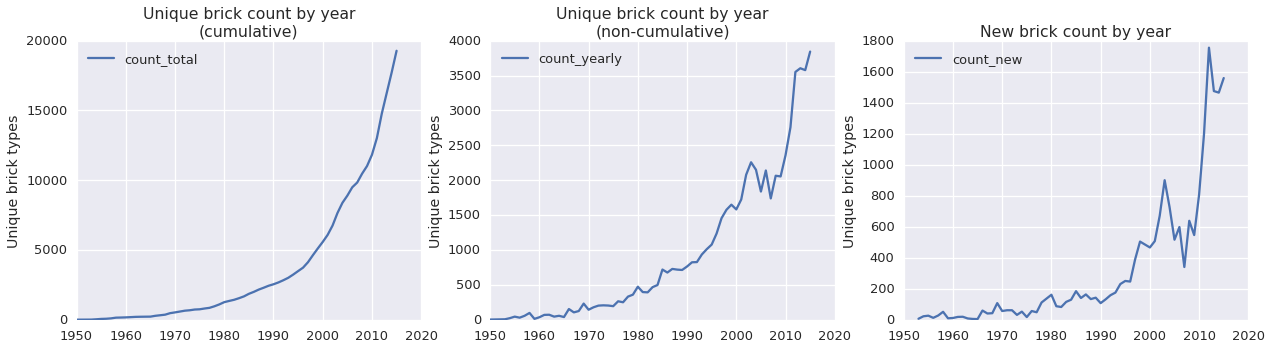

In [7]:
def plot_counts(df, fig, label=None):
    axes = fig.get_axes()
    
    axes[0].plot(df.year[:-1], df.count_total[:-1], label=label)
    axes[0].set_title('Unique brick count by year\n(cumulative)');
    axes[0].set_ylabel('Unique brick types');
    axes[0].legend(loc='best')
    
    axes[1].plot(df.year[:-1], df.count_yearly[:-1], label=label)
    axes[1].set_title('Unique brick count by year\n(non-cumulative)');
    axes[1].set_ylabel('Unique brick types');
    axes[1].legend(loc='best')

    axes[2].plot(df.year[:-1], df.count_new[:-1], label=label)
    axes[2].set_title('New brick count by year');
    axes[2].set_ylabel('Unique brick types');
    axes[2].legend(loc='best')

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,5))
plot_counts(pieces_by_year, fig)

Right off the bat we can see that there are a lot more Lego bricks than there used to be. The 90s were my Lego heydey, and since then the number of unique brick types has more than tripled; the situation is even more dramatic if your formative Lego experiences are from the 80s. (One other interesting note about these plots: Lego almost went bankrupt in 2003, and you can see signs of the turmoil that precipitated the crisis in the early 2000s and the fallout in the latter half of the decade.)

Not all bricks are created equal though: for every generally useful brick like a classic [2x4](https://rebrickable.com/parts/3001/brick-2-x-4) there's also a super-specialized brick like a '[61185c01](https://rebrickable.com/parts/61185c01)'. Or rather, there used to be; the perceived proliferation of specialized pieces is one of the major complaints behind the 'Legos aren't the creative toy they used to be' sentiment. Thanks to the data from Rebrickable we're in a position to address this impression quantitatively, so next let's investigate what types of bricks are most responsible for the increase.

The data contains category information for each brick type, however the categories as provided are a little too fine-grained to be useful. To make things a little simpler I assigned each of the 55 original categories to one of four new categories:

- Minifigures: minifigures and accessories, including plants and animals
- Bricks: everything that you use to build stuff
- Non-brick Lego: Lego products that aren't bricks, like Bionicle or Znap
- Other: everything else

We'll use this mapping from (complicated category) -> (simple category) to assign each piece to one of the simple categories.

In [8]:
# get list of which old categories map onto each new category 
new_categories = categories.fillna(0).apply(lambda row: row.nonzero())

# make a dictionary to map the 55 old type categories onto 4 new categories
# new categories: minifig, brick, non-brick lego, other
conversion_dict = {}
for new_cat in new_categories.index.values[1:]:
    old_index_array = new_categories.ix[new_cat][0]
    for i in old_index_array.tolist():
        conversion_dict[categories.iloc[i].category] = new_cat

pieces['simple_category'] = pieces.category.map(conversion_dict)

We want to look at the trends for 'basic' and 'specialized' bricks separately, so we need some way to separate the two types of bricks. Counting the number of different sets a particular brick type shows up in seems like a good way to do this; somewhat arbitrarily I'll say that any brick that occurs in less than 10 different Lego sets is 'specialized'.

In [9]:
BASIC_CUTOFF = 10

bricks = pieces.loc[pieces['simple_category'] == 'brick'].piece_id

set_count = set_pieces.loc[set_pieces.piece_id.isin(bricks)].groupby('piece_id').count()['set_id'].reset_index()
set_count.columns = ['piece_id','set_count']

basic_bricks = set_count.loc[set_count.set_count>=BASIC_CUTOFF].piece_id
special_bricks = set_count.loc[set_count.set_count<BASIC_CUTOFF].piece_id

pieces.loc[pieces.piece_id.isin(basic_bricks), 'simple_category'] = 'basic'
pieces.loc[pieces.piece_id.isin(special_bricks), 'simple_category'] = 'specialized'

Having assigned each brick type to one of our now five simple categories ('basic', 'specialized', 'minifig', 'non-brick lego', and 'other'), we can re-run the type counting analysis above on each subset of bricks.

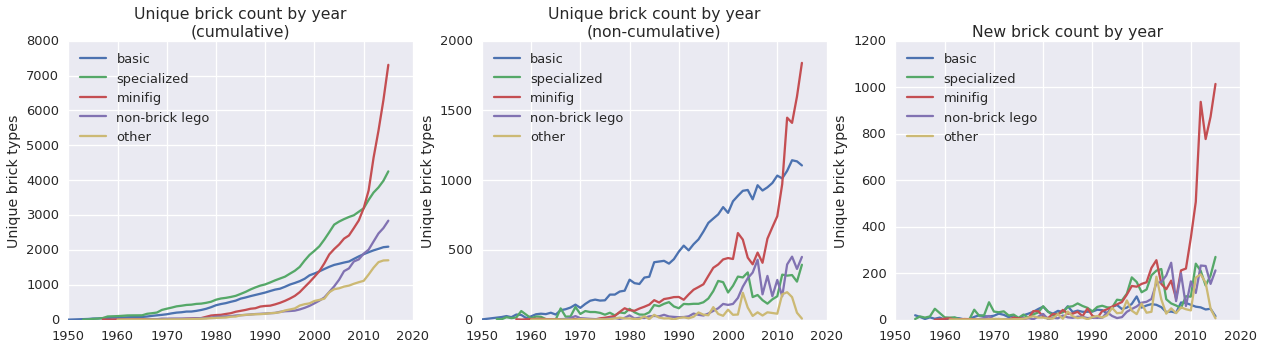

In [10]:
def count_pipeline(category, fig):
    # select the piece_ids of pieces in the category
    piece_ids = pieces.loc[pieces.simple_category==category]
    
    # filter out the pieces which aren't in that category
    raw_set_piece = set_pieces.loc[set_pieces.piece_id.isin(piece_ids.piece_id)]

    # run the pipeline
    sets_with_piece_list = get_sets_piece_list(raw_set_piece)
    pieces_by_year = get_pieces_by_year(sets_with_piece_list)
    plot_counts(pieces_by_year, fig, category)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,5))
category_list = ['basic', 'specialized', 'minifig', 'non-brick lego', 'other']

for category in category_list:
    count_pipeline(category, fig)

It looks like new minifigures account for a large fraction of the increase in brick types, especially since about 2010. There are definitely more minifigures than there used to be, however this also reflects the brick type labelling scheme -- remember that identical pieces with different prints count as different bricks, so each distinct minifigure counts as another new brick type. 

More to our original premise, we have what appear to be some conflicting trends in the 'specialized' vs. 'basic' brick type counts. Let's break those out into their own plots for a closer look.

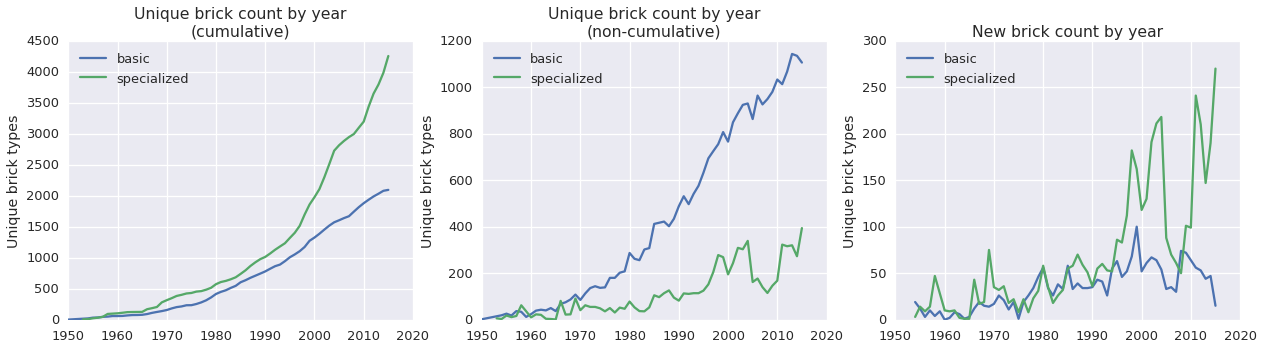

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,5))
category_list = ['basic', 'specialized']

for category in category_list:
    count_pipeline(category, fig)

The cumulative number of specialized bricks is higher than the number of basic bricks, and in most years since ~1995 there have been more new specialized bricks introduced than basic bricks, but in any given year there are many more basic than specialized brick types. To me, this suggests that a basic brick type, once introduced, stays in the rotation, while a specialized brick is introduced, used once or twice that year, and then phased out of production. 

These trends, especially the new brick count by year, seem to support the 'Lego has gotten too specialized' argument. Up until about 1995 new 'basic' and 'specialized' bricks were being created at about the same rate, but since then specialized bricks have substantially outpaced basic bricks, except for a brief period in the late 2000s, which was presumably a result of the near-bankruptcy in 2003.

This speaks to the 'How has Lego changed?' question that motivates this analysis, but the conclusion so far is still weak because it doesn't account for how common each type of brick is. Next we'll expand on this analysis by looking at the distribution of bricks in a given year's sets.

# Yearly brick frequency distributions

The number of brick types produced in a given year is an interesting metric, but it doesn't capture much information about how suitable that year's Legos are for creative play. Who cares if a set has a handful of overly specific bricks if that same set also has tons of basic bricks? Looking at brick frequency distributions should provide a better indication of how Lego sets are changing: if Lego sets have come to rely too heavily on lots of specialized, single-use bricks then we should see the distribution of brick frequencies shift towards smaller values. Alternatively, if Lego sets contain about the same proportion of generally useful bricks as they did in the past then the frequency distribution should look the same, just scaled up.

To calculate the brick frequency distributions we'll add up how many of each brick type each Lego set contains, and then sum over all the sets in a given year. 

In [12]:
# count number of each piece_id in each set
set_piece_count = set_pieces_trimmed.groupby(['set_id','piece_id','color']).first().sum(level=[0,1])

# add a year column
set_piece_count_year = set_piece_count.join(sets_trimmed.year)

# sum piece counts over the sets in each year
sum_piece_count = set_piece_count_year.reset_index().groupby(['year','piece_id']).sum()

# pivot the data for plotting
pivoted = sum_piece_count.reset_index().pivot(index='piece_id', columns='year', values='num')

The brick frequncy distribution has a long tail, so we'll use logarithmic bins for the histogram.

/home/henry/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


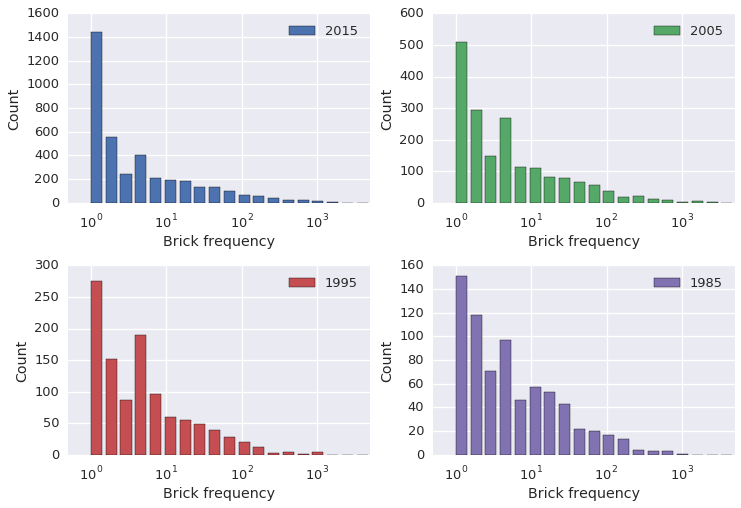

In [56]:
def histo_label(ax):
    ax.set_xlim([0.5, 5E3])
    ax.set_xscale('log')
    ax.set_xlabel('Brick frequency')
    ax.set_ylabel('Count')
    ax.legend()
    
def plot_freq_hist(freqs, label, color, ax):
    # distribution is long-tailed, so use log-size bins
    log_bins = np.array([math.exp(x) for x in np.linspace(0,math.log(5E4),25)])
    counts, bin_edges = np.histogram(freqs,bins=log_bins)
        
    ax.bar(bin_edges[:-1], counts, width=0.4*log_bins[:-1], color=color, label=label)
    histo_label(ax)
    
# need explicit coloring bc plt.bar doesn't auto-increment color
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2)
for year, color, ax in zip([2015,2005,1995,1985], sns.color_palette()[:4], [ax1,ax2,ax3,ax4]):
    plot_freq_hist(pivoted[year].dropna(), year, color, ax)
plt.tight_layout()

Looking at the frequency distributions, there are undeniably more specialized bricks than there used to be -- the leftmost bin, corresponding to brick types which show up only once, becomes larger and larger relative to the rest of the distrubtion as we progress from 1985 to 2015. But this is just what we saw earlier when we counted unique brick types; what's more interesting is how the other end of the distribution has changed. The different y-axis scales make it somewhat hard to see, but the tail has gotten both longer and fatter. Let's zoom in on the high frequency region to see this. 

/home/henry/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


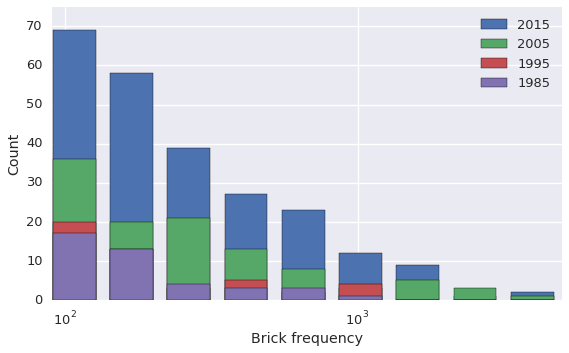

In [57]:
# need explicit coloring bc plt.bar doesn't auto-increment color
fig, ax = plt.subplots(1,1, figsize=(8,5))
for year, color in zip([2015,2005,1995,1985], sns.color_palette()[:4]):
    plot_freq_hist(pivoted[year].dropna(), year, color, ax)

ax.set_xlim([90, 5E3])
ax.set_ylim([0,75])
plt.tight_layout()

In 1985 there was a single brick type that showed up more than 1000 times in that year's sets, in 2015 there were more than 25. There might be more specialized bricks than there used to be, but there are also way, way more general purpose bricks as well. The question is, 'Has the relative growth in the number of specialized bricks outpaced the growth in basic bricks?' 

It's important to note that we're talking about the number of *bricks*, not the number of brick *types* here -- we've already established that the number of specialized brick *types* is growing faster, now we want to know if that means that we end up with more of the specialized bricks themselves.

It's hard to say, just by looking at the histograms, whether this is the case (especially since we're using a logarithmic scale). To make things easier, let's borrow the idea of a [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) and apply it to the yearly collection of bricks. (The year's 'collection' of bricks is what you'd end up with if you bought one of every set released that year). Roughly speaking, a cumulative distribution function tells you what fraction of a total distribution is accounted for by a given subset of the elements in the distribution. In our case, the 'Collection CDF' will tell us what fraction of the total number of bricks in a given year are accounted for by a given subset of brick types.

To generate our collection CDF we'll proceed in two steps:

- Rank each brick type by frequency, then normalize by the number of brick types that year. These are our x values.
- Take the cumulative sum of the ranked brick frequencies, then normalize by the total number of bricks that year. These are our y values.

The resulting curve will tell us what fraction of our collection is made up of bricks in the bottom *x* percent of brick types.

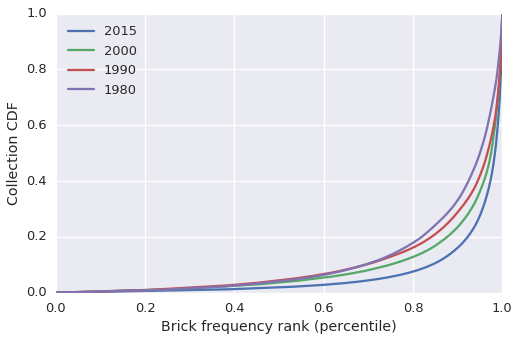

In [15]:
def plot_rank_cdf(year, ax):
    
    freqs = pivoted[year].dropna().sort_values()
    # use ordinal ranking so our curve is smooth
    ranks = rankdata(freqs, method='ordinal')
    cum_counts = np.cumsum(freqs)
    
    ax.plot(ranks / max(ranks), cum_counts / max(cum_counts))

    ax.set_xlabel('Brick frequency rank (percentile)')
    ax.set_ylabel('Collection CDF')
    ax.legend(loc=2)
    
fig, ax = plt.subplots(1,1, figsize=(8,5))

for year in [2015,2000,1990,1980]:
    plot_rank_cdf(year, ax)

In 2015, the bottom 80% of brick types, by frequency, accounted for a little under 10% of all the bricks in that year's collection, in 1980 they accounted for about 20% of the collection. The same trend holds true for the rest of the curve: rare brick types account for a smaller fraction of the yearly collection in 2015 than they did in 1980. In other words, we can definitively answer the question posed a few paragraphs ago: No, the relative growth in the number of specialized bricks has not outpaced the growth in basic bricks. There are a lot more uncommon, specialized brick types, however in aggregate, they make up a smaller fraction of the yearly Lego collection than they did in the past.

So what happened with Legos? They made a lot more of them. In doing so, they made a lot of new, specialized bricks, but they made even more general purpose bricks. This trend is easily obscured by the opposite trend in the number of brick *types*, but from a 'creative play' standpoint the bricks you actually end up with are more important than the bricks you could have ended up with. 